## European Restaurant Reviews
Reviews of various European restaurants by customers.
This dataset contains customer reviews for various restaurants, divided into positive and negative sentiments. Reviews are crucial for each restaurant’s reputation and are updated daily.

https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews

In [1]:
import os
print(os.getcwd())

C:\Users\HENNY PURWADI\PYTHON\FT_Embed\FineTune_Embed


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', 160)

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

import joblib
import pickle
from imblearn.over_sampling import SMOTE

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,TrainerCallback
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read CSV file
df = pd.read_csv('./data/Reviews.csv')
df.head(2)

,Sentiment,Label,Review
0,Negative,0,Rude managerThe manager became agressive when I said the carbonara was not good. She was rude. It was a very bad experience. The worst in Rome in many years.
1,Negative,0,"A big disappointmentI ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20..."


In [5]:
len(df)

1502

In [6]:
df.columns

Index(['Sentiment', 'Label', 'Review'], dtype='object')

In [7]:
#Find unique values in df['Sentiment'] 
unique_Sentiment= df['Sentiment'] .unique()
df_Sentiment_counts = df['Sentiment'].value_counts()
df_Sentiment_counts

Sentiment
Positive    1237
Negative     265
Name: count, dtype: int64

### There is an imbalanced dataset of sentiments between Positive and Negative

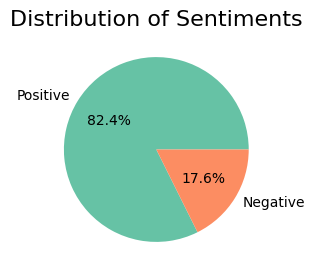

In [9]:
plt.figure(figsize=(3, 3))
plt.pie(df_Sentiment_counts, labels=df_Sentiment_counts.index, autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Sentiments', fontsize=16)
plt.show()

Unlike traditional Machine Learning Models like Logistic Regression, Random Forest, or SVM, which need to convert text data into a numerical format, when using BERT or similar pre-trained transformer models, we don't need to apply traditional text preprocessing steps like TF-IDF, regex cleaning, or other NLP techniques like stemming or lemmatization. BERT models handle these preprocessing steps internally, including tokenization and handling of special characters.

### Fine-tunes DistilBertForSequenceClassification and balancing the imbalanced dataset in the Reviews dataset.

1. Fine-tuning : Directly fine-tune DistilBertForSequenceClassification on the EuropeanRestaurantReviews dataset.

2. Evaluation: Evaluate the fine-tuned model.
   
3. Saving and Loading the Model: Save the fine-tuned model and load it for making predictions.

4. Prediction Function: Use the fine-tuned model to predict sentiment directly from user input.

In [17]:
# Preprocess the text data using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [19]:
# Function to tokenize data
def tokenize_data(reviews, labels):
    encodings = tokenizer(reviews, truncation=True, padding=True, max_length=128)
    dataset = [{'input_ids': torch.tensor(encodings['input_ids'][i]),
                'attention_mask': torch.tensor(encodings['attention_mask'][i]),
                'labels': torch.tensor(labels[i])} for i in range(len(reviews))]
    return dataset

In [21]:
# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Review'], df['Label'], test_size=0.3, random_state=42)

train_dataset = tokenize_data(train_texts.tolist(), train_labels.tolist())
test_dataset = tokenize_data(test_texts.tolist(), test_labels.tolist())

In [22]:
# Calculate class weights for handling imbalanced data
class_weights = torch.tensor([len(train_labels) / (len(np.unique(train_labels)) * np.bincount(train_labels))], dtype=torch.float)
class_weights = class_weights.squeeze()

In [23]:
# Load DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tuning DistilBertForSequenceClassification Model

In [28]:
# Training arguments for fine-tuning DistilBERT

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

# Compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

To include a chart of performance, including the loss, in the training process, need to extend the Trainer class to log the loss values during training and evaluation. After training, we can plot these metrics to visualize the performance

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.652600,0.598996,0.933481,0.960422,0.955381,0.965517
2,0.130100,0.135509,0.971175,0.982690,0.986631,0.978780
3,0.166300,0.179355,0.975610,0.985507,0.979058,0.992042
4,0.039500,0.188477,0.977827,0.986737,0.986737,0.986737
5,0.018300,0.196552,0.973392,0.984043,0.986667,0.981432


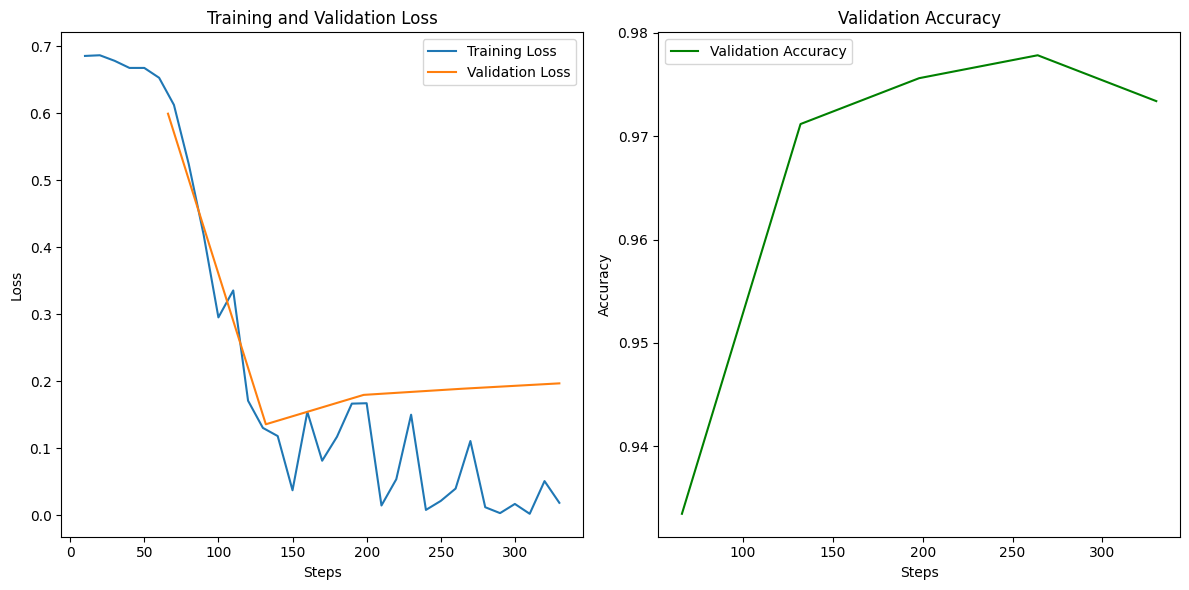

In [30]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback

# Callback to log loss and metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {'train_loss': [], 'eval_loss': [], 'eval_accuracy': []}
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.metrics['train_loss'].append((state.global_step, logs['loss']))
        if 'eval_loss' in logs:
            self.metrics['eval_loss'].append((state.global_step, logs['eval_loss']))
        if 'eval_accuracy' in logs:
            self.metrics['eval_accuracy'].append((state.global_step, logs['eval_accuracy']))

# Subclass Trainer to override compute_loss method and include metrics callback
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Trainer initialization
metrics_callback = MetricsCallback()
trainer = WeightedTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback],  # Add metrics callback to the trainer
)

# Train the model
trainer.train()

# Plot the loss and accuracy curves
train_loss = metrics_callback.metrics['train_loss']
eval_loss = metrics_callback.metrics['eval_loss']
eval_accuracy = metrics_callback.metrics['eval_accuracy']

train_steps, train_losses = zip(*train_loss)
eval_steps, eval_losses = zip(*eval_loss)
_, eval_accuracies = zip(*eval_accuracy)

plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_losses, label='Training Loss')
plt.plot(eval_steps, eval_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Evaluate the model
metrics = trainer.evaluate()
print("Metrics:", metrics)

Metrics: {'eval_loss': 0.18847709894180298, 'eval_accuracy': 0.9778270509977827, 'eval_f1': 0.986737400530504, 'eval_precision': 0.986737400530504, 'eval_recall': 0.986737400530504, 'eval_runtime': 14.3048, 'eval_samples_per_second': 31.528, 'eval_steps_per_second': 2.027, 'epoch': 5.0}


#### Interpretation: Fine Tuning increase the performance.

### Save the fine-tuned model

In [40]:
# Save the fine-tuned model
model.save_pretrained('./data/fine-tuned-distilbert')
tokenizer.save_pretrained('./data/fine-tuned-distilbert')

print("Fine-tuning complete and model saved.")

Fine-tuning complete and model saved.


In [41]:
# Load the fine-tuned model for predictions
def load_fine_tuned_model():
    model = DistilBertForSequenceClassification.from_pretrained('./data/fine-tuned-distilbert')
    tokenizer = DistilBertTokenizer.from_pretrained('./data/fine-tuned-distilbert')
    return model, tokenizer

In [42]:
fine_tuned_model, fine_tuned_tokenizer = load_fine_tuned_model()

In [43]:
# Predict Sentiment based on user input

def predict():
    user_input = input("Enter your message: ")
    encodings = fine_tuned_tokenizer(user_input, truncation=True, padding=True, max_length=128, return_tensors='pt')
    with torch.no_grad():
        outputs = fine_tuned_model(**encodings)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    print('Prediction:', 'Positive' if prediction == 1 else 'Negative')

In [44]:
predict()

Enter your message:  The manager was rude


Prediction: Negative


In [45]:
predict()

Enter your message:  The food is delicious


Prediction: Positive


In [46]:
predict()

Enter your message:  The wine tasted bad


Prediction: Negative


#### After Fine-Tuned, the DistilBertForSequenceClassification model can predict the sentiment better

In [60]:
# Get predictions for the test set
test_encodings = fine_tuned_tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_outputs = fine_tuned_model(**test_encodings)
test_preds = torch.argmax(test_outputs.logits, dim=1).numpy()

In [61]:
# Calculate accuracy score
accuracy = accuracy_score(test_labels, test_preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9778


In [62]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
nconf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis], 2)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 69   5]
 [  5 372]]


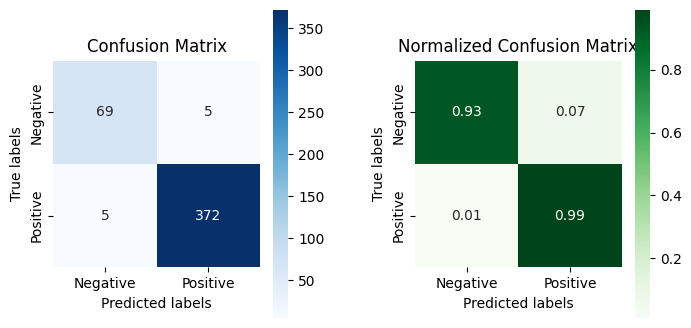

In [63]:
# Plot heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Blues, fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax1)
ax1.set_xlabel("Predicted labels")
ax1.set_ylabel("True labels")
ax1.set_title("Confusion Matrix")
sns.heatmap(nconf_matrix, annot=True, cmap=plt.cm.Greens, fmt=".2f", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax2)
ax2.set_xlabel("Predicted labels")
ax2.set_ylabel("True labels")
ax2.set_title("Normalized Confusion Matrix")

# Add some space between the subplots
plt.subplots_adjust(wspace=0.4)

# Set the aspect ratio to "equal"
ax1.set_aspect("equal")
ax2.set_aspect("equal")

plt.show()